### Housing Violations Dataset Exploration

Benny Cohen

11/06/2019


Now that we have all of our data, we want to start finding trends and visualizing the data. We come into this asking some very elementary questions. At this point we have no buisness objective although we may notice something and want to delve further into it. We simply want to see what our data looks like. 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [16]:
df = pd.read_csv('../data/clean.csv', parse_dates = ['inspectiondate', 'certifieddate', 'originalcorrectbydate',
                                                     'currentstatusdate']).drop('newcorrectbydate',axis=1)

In [18]:
df.count()

violationid              49371
buildingid               49371
boro                     49371
zip                      49371
inspectiondate           49371
certifieddate             8661
originalcorrectbydate    48815
novdescription           49371
class                    49371
currentstatus            49371
currentstatusdate        49371
currentstatusdate        49371
dtype: int64

So we see we have a lot of rows to work with. Now on a most basic level we want to see what the status of these violations are

In [25]:
statusCounts = df.currentstatus.value_counts()
statusCounts

VIOLATION CLOSED                            41359
VIOLATION DISMISSED                          4090
FIRST NO ACCESS TO RE- INSPECT VIOLATION     1496
NOT COMPLIED WITH                            1334
NOV SENT OUT                                  488
DEFECT LETTER ISSUED                          185
NOV CERTIFIED LATE                            176
SECOND NO ACCESS TO RE-INSPECT VIOLATION      146
INVALID CERTIFICATION                          35
VIOLATION WILL BE REINSPECTED                  31
FALSE CERTIFICATION                            21
INFO NOV SENT OUT                               6
CIV14 MAILED                                    1
CERTIFICATION POSTPONMENT DENIED                1
NOTICE OF ISSUANCE SENT TO TENANT               1
VIOLATION REOPEN                                1
Name: currentstatus, dtype: int64

Interestingly enough, most of the cases are closed. Now what can cause a violation to be closed? According to the dataset description... `The violation status is closed when the violation is observed/verified as corrected by HPD or as certified by the landlord.`

This leads to a noteworthy first observation: *Most violations are in fact corrected for*

Now of the ones that aren't... some have been dissmissed, meaning taken away with. Some were not complied with, and others are still in the early stages of processing. Let's normalize these numbers by turning them into percents so that they are easier to look at. 

In [26]:
total = df.currentstatus.value_counts().sum()
statusCounts/total * 100

VIOLATION CLOSED                            83.771850
VIOLATION DISMISSED                          8.284215
FIRST NO ACCESS TO RE- INSPECT VIOLATION     3.030119
NOT COMPLIED WITH                            2.701991
NOV SENT OUT                                 0.988435
DEFECT LETTER ISSUED                         0.374714
NOV CERTIFIED LATE                           0.356485
SECOND NO ACCESS TO RE-INSPECT VIOLATION     0.295720
INVALID CERTIFICATION                        0.070892
VIOLATION WILL BE REINSPECTED                0.062790
FALSE CERTIFICATION                          0.042535
INFO NOV SENT OUT                            0.012153
CIV14 MAILED                                 0.002025
CERTIFICATION POSTPONMENT DENIED             0.002025
NOTICE OF ISSUANCE SENT TO TENANT            0.002025
VIOLATION REOPEN                             0.002025
Name: currentstatus, dtype: float64

Viewing the numbers like this makes it really clear that most cases were closed, a whopping 80 percent.

Now this begs the obvious question: Why?
Here are a couple of possibilities...
1. Records tend to only be entered into the system when they are closed. 
2. We are looking at data from a very narrow time span.

Now 1 would be a data entry problem. 2 though we could really easily verify. Let's graph number of incidents per month...
This is going to be scary though since we need to sort the data to construct a line plot. 

In [36]:
df['monthCurrentStatus'] = df.currentstatusdate.dt.to_period('M') #First we extract the months/year
sorted_df = df.sort_values('monthCurrentStatus') # beware.... this is slow....That's why I got rid of days. 

In [54]:
counts = sorted_df.groupby('monthCurrentStatus').count().sum(axis=1) #Yes we could use value_counts but then we have to resort
counts.head()

monthCurrentStatus
2006-07    11
2007-06    22
2008-06    22
2008-08    24
2008-12    11
Freq: M, dtype: int64

Text(0.5, 1.0, 'Number of Incidents over Time')

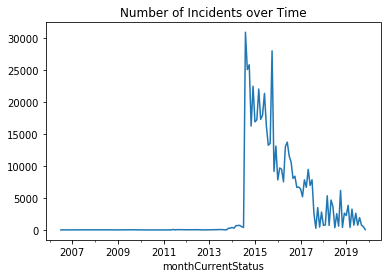

In [58]:
counts.plot()
plt.title("Number of Incidents Statuses over Time")

Now we immediatly see that a lot our incidents were torwards the end of 2014 and less were reported since then. 
This doesn't iteself answer our original question of why are almost all the statuses closed but it seems like most of the data was entered during this period when the data was marked as completed.

Another important question we have to ask ourselves is what are these incidents? Our dataset provides us with a column that can help us answer this by telling us how severe incidents are

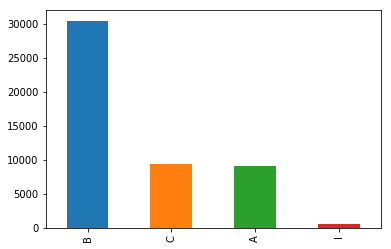

In [62]:
class_counts = df['class'].value_counts()
class_counts.plot.bar()

We see that B incidents, medium severity are the majority. Class C incidents, the highest seriousness is about equal with A, low seriousness. Class I aren't really violations but simply informational notices ('thus the letter i')

So now we contextualized our data a bit more... We know when the data was from and we know the what: that most of the rows show that the incidents were resolved and most are medium severity. Let's now focus on the where. Where do most incidents take place? Also which areas are there the most severe incidents?

Text(0.5, 1.0, 'Incidents per boro')

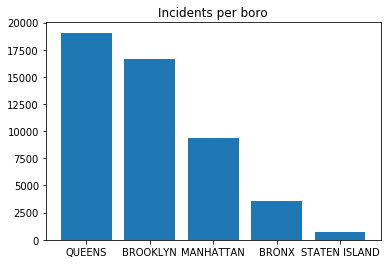

In [79]:
plt.bar(df['boro'].unique(), df['boro'].value_counts())
plt.title("Incidents per boro")

Queens has the most number of incidents with Manhattan, the Bronx, and Staten Island significantly less.

Now let's try to see if there is anything problematic about how long each boro takes to respond to incidents

In [80]:
inspection_date = df['inspectiondate']
current_status_date = df['currentstatusdate']

In [81]:
df['days_between'] = pd.to_timedelta(current_status_date - inspection_date, unit='d').dt.days
closed_issues = df[df['currentstatus'] == 'VIOLATION CLOSED']

In [82]:
daysOpenDf = closed_issues[['days_between', 'boro']]
daysOpenDf.head()

,days_between,boro
0,8066,QUEENS
1,7568,QUEENS
2,7568,QUEENS
3,7566,QUEENS
4,11005,BROOKLYN


In [83]:
daysOpenSeries = daysOpenDf.groupby('boro').median() #median to ignore outliers 

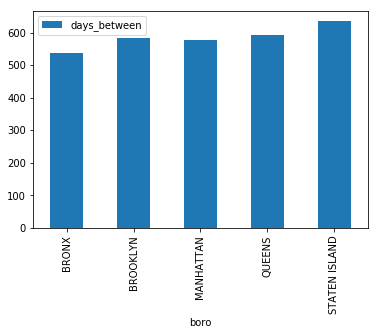

In [84]:
daysOpenSeries.plot.bar()

Staten Island seems to take the longest to repond to incidents. They also have the fewest number of incidents so this difference might not be significant. It's a pretty noteworthy observation that these numbers don't differ so much. 